<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Marketing_chap_9_Customer_lifetime_value_(expand_chap_5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline

#ML algorithm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.linear_model import TheilSenRegressor, HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures


# ensembles
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

#New from Matt cookbook
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV


from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error,median_absolute_error

#Visual
from sklearn.inspection import plot_partial_dependence

In [36]:
df=pd.read_excel('https://github.com/mrinmaisharma/Online-Retail-Dataset/blob/master/OnlineRetail.xlsx?raw=true',sep=';')
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Attribute Information:

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides.

CLV

In marketing, the CLV is one of the key metrics to have and monitor. The CLV measures
customers' total worth to the business over the course of their lifetime relationship with the
company. This metric is especially important to keep track of for acquiring new customers.
It is generally more expensive to acquire new customers than to keep existing customers, so
knowing the lifetime value and the costs associated with acquiring new customers is
essential in order to build marketing strategies with a positive ROI. For example, if the
average CLV of your customer is 100 and it only costs 10 to acquire a new customer, then
your business will be generating more revenue as you acquire new customers.

Because we do not typically know the lifetime span of customers, we often try to estimate
CLV over the course of a certain period. It can be done by estimating a customer's 12-month
CLV, 24-month CLV, or can also be a 3-month CLV. Aside from the method we discussed
through an example, CLV can also be estimated through building predictive models. Using
machine learning algorithms and customers' purchase history data, we can build machine
learning models that predict customers' CLV over the course of a certain period. In the
programming exercises in this chapter, we are going to learn how to build a regression
model that predicts customers' 3-month CLV.

# Data Clean-Up


- Negative Quantity

In [37]:
df.loc[df['Quantity'] <= 0].shape

(10624, 8)

In [38]:
df = df.loc[df['Quantity'] > 0]

In [39]:
df.shape

(531285, 8)

In [40]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133361
Country             0
dtype: int64

- Missing CustomerID

In [41]:
df = df[pd.notnull(df['CustomerID'])]
df.shape

(397924, 8)


- Excluding Incomplete Month

In [42]:
print('Date Range: %s ~ %s' % (df['InvoiceDate'].min(), df['InvoiceDate'].max()))

Date Range: 2010-12-01 08:26:00 ~ 2011-12-09 12:50:00


In [43]:

df.loc[df['InvoiceDate'] >= '2011-12-01'].shape

(17304, 8)

In [44]:

df = df.loc[df['InvoiceDate'] < '2011-12-01']
df.shape

(380620, 8)

- Total Sales

In [45]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34



- Per Order Data

In [46]:
orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({
    'Sales': sum,
    'InvoiceDate': max
})
orders_df

Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00
...                        ...                 ...
18283.0    578262       313.65 2011-11-23 13:27:00
           579673       223.61 2011-11-30 12:59:00
18287.0    554065       765.28 2011-05-22 10:39:00
           570715      1001.32 2011-10-12 10:23:00
           573167        70.68 2011-10-28 09:29:00

[17758 rows x 2 columns]

# Data Analysis

In [47]:
def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg' # No need
groupby_count.__name__ = 'count' # No need
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

In [48]:
summary_df = orders_df.reset_index().groupby('CustomerID').agg({
    'Sales': [min, max, sum, groupby_mean, groupby_count],
    'InvoiceDate': [min, max, purchase_duration, avg_frequency]
})
print(summary_df.shape)
summary_df.head()

(4298, 9)


Sales            ...       InvoiceDate                   
                 min       max  ... purchase_duration purchase_frequency
CustomerID                      ...                                     
12346.0     77183.60  77183.60  ...                 0                0.0
12347.0       382.52   1294.32  ...               327               54.5
12348.0       227.44    892.80  ...               282               70.5
12349.0      1757.55   1757.55  ...                 0                0.0
12350.0       334.40    334.40  ...                 0                0.0

[5 rows x 9 columns]

In [49]:
summary_df.columns = ['_'.join(col).lower() for col in summary_df.columns]
summary_df

,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
CustomerID,,,,,,,,,
12346.0,77183.60,77183.60,77183.60,77183.600000,1.0,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.000000
12347.0,382.52,1294.32,4085.18,680.863333,6.0,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.500000
12348.0,227.44,892.80,1797.24,449.310000,4.0,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.500000
12349.0,1757.55,1757.55,1757.55,1757.550000,1.0,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.000000
12350.0,334.40,334.40,334.40,334.400000,1.0,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.000000
...,...,...,...,...,...,...,...,...,...
18280.0,180.60,180.60,180.60,180.600000,1.0,2011-03-07 09:52:00,2011-03-07 09:52:00,0,0.000000
18281.0,80.82,80.82,80.82,80.820000,1.0,2011-06-12 10:53:00,2011-06-12 10:53:00,0,0.000000
18282.0,100.21,100.21,100.21,100.210000,1.0,2011-08-05 13:35:00,2011-08-05 13:35:00,0,0.000000


In [50]:
summary_df.shape

(4298, 9)

In [51]:
summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]

In [52]:
summary_df.shape

(2692, 9)

As you can see from this code, we clean up the column names of the
DataFrame, summary_df, in the first line. Then, we are only taking the customers who have
made at least two or more purchases, which represents repeat customers. Lastly, we group
by the sales_count column and count how many customers belong to each category. The
resulting plot looks as follows:

In [54]:

summary_df['sales_count'].describe()

count    2692.000000
mean        5.971025
std         8.878128
min         2.000000
25%         2.000000
50%         4.000000
75%         6.000000
max       201.000000
Name: sales_count, dtype: float64

In [55]:
summary_df['sales_avg'].describe()

count     2692.000000
mean       391.458687
std        465.584404
min          3.450000
25%        197.661000
50%        306.043333
75%        444.524000
max      14844.766667
Name: sales_avg, dtype: float64

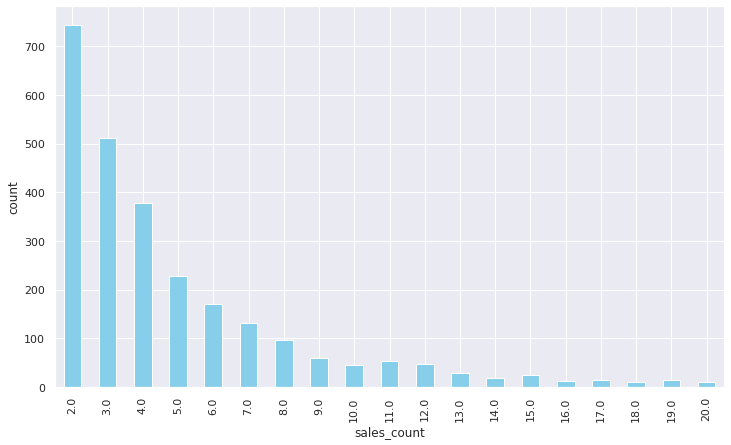

In [53]:
ax = summary_df.groupby('sales_count').count()['sales_avg'][:20].plot(
    kind='bar', 
    color='skyblue',
    figsize=(12,7), 
    grid=True
)

ax.set_ylabel('count')

plt.show()

As you can see from this plot, the majority of customers have made 10 or less purchases
historically. Let's take a look at the average number of days between purchases for these
repeat customers. Take a look at the following code first:

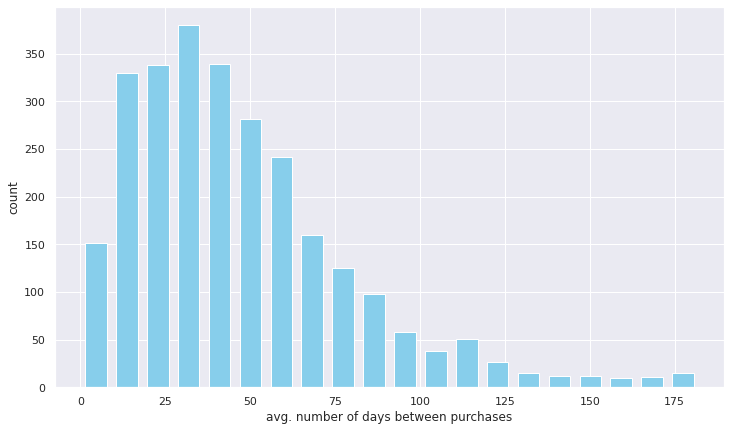

In [56]:
ax = summary_df['invoicedate_purchase_frequency'].hist(
    bins=20,
    color='skyblue',
    rwidth=0.7,
    figsize=(12,7)
)

ax.set_xlabel('avg. number of days between purchases')
ax.set_ylabel('count')

plt.show()

This plot tells us the overall view of how frequently repeat customers made purchases
historically. As you can see from this plot, the majority of repeat customers made purchases
every 20 to 50 days.

In [57]:
summary_df['invoicedate_purchase_frequency'].describe()

count    2692.000000
mean       46.999022
std        32.395004
min         0.029412
25%        23.500000
50%        40.500000
75%        62.333333
max       182.000000
Name: invoicedate_purchase_frequency, dtype: float64

In [58]:
summary_df['invoicedate_purchase_duration'].describe()

count    2692.000000
mean      199.720282
std       107.816559
min         1.000000
25%       107.000000
50%       209.000000
75%       296.000000
max       364.000000
Name: invoicedate_purchase_duration, dtype: float64

# Predicting the 3 month CLV

##  Data Preparation

In [72]:
a=orders_df.reset_index()
a[a.CustomerID==12348.0]

,CustomerID,InvoiceNo,Sales,InvoiceDate
7,12348.0,539318,892.80,2010-12-16 19:09:00
8,12348.0,541998,227.44,2011-01-25 10:42:00
9,12348.0,548955,367.00,2011-04-05 10:47:00
10,12348.0,568172,310.00,2011-09-25 13:13:00


In [68]:
clv_freq = '3M'

data_df = orders_df.reset_index().groupby([
    'CustomerID',
    pd.Grouper(key='InvoiceDate', freq=clv_freq)
]).agg({
    'Sales': [sum, groupby_mean, groupby_count],
})

data_df

Sales                    
                             sum           avg count
CustomerID InvoiceDate                              
12346.0    2011-03-31   77183.60  77183.600000   1.0
12347.0    2010-12-31     711.79    711.790000   1.0
           2011-03-31     475.39    475.390000   1.0
           2011-06-30    1018.77    509.385000   2.0
           2011-09-30     584.91    584.910000   1.0
...                          ...           ...   ...
18283.0    2011-06-30     524.68    131.170000   4.0
           2011-09-30     278.09     92.696667   3.0
           2011-12-31     766.21    153.242000   5.0
18287.0    2011-06-30     765.28    765.280000   1.0
           2011-12-31    1072.00    536.000000   2.0

[9220 rows x 3 columns]

In [73]:

data_df.columns = ['_'.join(col).lower() for col in data_df.columns]
data_df = data_df.reset_index()
data_df.head(10)

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count
0,12346.0,2011-03-31,77183.60,77183.600,1.0
1,12347.0,2010-12-31,711.79,711.790,1.0
2,12347.0,2011-03-31,475.39,475.390,1.0
3,12347.0,2011-06-30,1018.77,509.385,2.0
4,12347.0,2011-09-30,584.91,584.910,1.0
5,12347.0,2011-12-31,1294.32,1294.320,1.0
6,12348.0,2010-12-31,892.80,892.800,1.0
7,12348.0,2011-03-31,227.44,227.440,1.0
8,12348.0,2011-06-30,367.00,367.000,1.0
9,12348.0,2011-09-30,310.00,310.000,1.0


In [74]:
date_month_map = {
    str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(
        sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True)
    )
}
date_month_map

{'2010-12-31': 'M_5',
 '2011-03-31': 'M_4',
 '2011-06-30': 'M_3',
 '2011-09-30': 'M_2',
 '2011-12-31': 'M_1'}

In [75]:
data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[str(x)[:10]])
data_df['M']

0       M_4
1       M_5
2       M_4
3       M_3
4       M_2
       ... 
9215    M_3
9216    M_2
9217    M_1
9218    M_3
9219    M_1
Name: M, Length: 9220, dtype: object

In [76]:

data_df.head(10)

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count,M
0,12346.0,2011-03-31,77183.60,77183.600,1.0,M_4
1,12347.0,2010-12-31,711.79,711.790,1.0,M_5
2,12347.0,2011-03-31,475.39,475.390,1.0,M_4
3,12347.0,2011-06-30,1018.77,509.385,2.0,M_3
4,12347.0,2011-09-30,584.91,584.910,1.0,M_2
5,12347.0,2011-12-31,1294.32,1294.320,1.0,M_1
6,12348.0,2010-12-31,892.80,892.800,1.0,M_5
7,12348.0,2011-03-31,227.44,227.440,1.0,M_4
8,12348.0,2011-06-30,367.00,367.000,1.0,M_3
9,12348.0,2011-09-30,310.00,310.000,1.0,M_2


- Building Sample Set

In [95]:
features_df = pd.pivot_table(
    data_df.loc[data_df['M'] != 'M_1'], 
    values=['sales_sum', 'sales_avg', 'sales_count'], 
    columns='M', 
    index='CustomerID'
)
features_df.head()

sales_avg                      ... sales_sum                  
M                M_2      M_3        M_4  ...       M_3       M_4     M_5
CustomerID                                ...                            
12346.0          NaN      NaN  77183.600  ...       NaN  77183.60     NaN
12347.0       584.91  509.385    475.390  ...   1018.77    475.39  711.79
12348.0       310.00  367.000    227.440  ...    367.00    227.44  892.80
12350.0          NaN      NaN    334.400  ...       NaN    334.40     NaN
12352.0       316.25      NaN    312.362  ...       NaN   1561.81     NaN

[5 rows x 12 columns]

In [96]:
features_df.columns = ['_'.join(col) for col in features_df.columns]
features_df.shape

(3616, 12)

In [97]:
features_df.head(10)

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12346.0,NaN,NaN,77183.600,NaN,NaN,NaN,1.0,NaN,NaN,NaN,77183.60,NaN
12347.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
12348.0,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
12350.0,NaN,NaN,334.400,NaN,NaN,NaN,1.0,NaN,NaN,NaN,334.40,NaN
12352.0,316.25,NaN,312.362,NaN,2.0,NaN,5.0,NaN,632.50,NaN,1561.81,NaN
12353.0,NaN,89.000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,89.00,NaN,NaN
12354.0,NaN,1079.400,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1079.40,NaN,NaN
12355.0,NaN,459.400,NaN,NaN,NaN,1.0,NaN,NaN,NaN,459.40,NaN,NaN
12356.0,NaN,481.460,2271.620,NaN,NaN,1.0,1.0,NaN,NaN,481.46,2271.62,NaN


In [98]:
features_df = features_df.fillna(0)
features_df.head()

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12346.0,0.00,0.000,77183.600,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00
12347.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
12348.0,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
12350.0,0.00,0.000,334.400,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00
12352.0,316.25,0.000,312.362,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00


In [99]:
data_df.head()

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count,M
0,12346.0,2011-03-31,77183.60,77183.600,1.0,M_4
1,12347.0,2010-12-31,711.79,711.790,1.0,M_5
2,12347.0,2011-03-31,475.39,475.390,1.0,M_4
3,12347.0,2011-06-30,1018.77,509.385,2.0,M_3
4,12347.0,2011-09-30,584.91,584.910,1.0,M_2


Now that we have built the features DataFrame, let's build the target variables. Take a look
at the following code:

In [100]:
response_df = data_df.loc[
    data_df['M'] == 'M_1',
    ['CustomerID', 'sales_sum']
]
response_df.head()

,CustomerID,sales_sum
5,12347.0,1294.32
10,12349.0,1757.55
14,12352.0,311.73
20,12356.0,58.35
21,12357.0,6207.67


As you can see from this code, we are taking the last 3 month period, the M_1 group, as the
target variable. The target column will be sales_sum, as we want to predict the next 3
month customer value, which is the total purchase amount that a given customer is likely to
make in the next 3 months. The target variable looks like the following:

In [101]:
response_df.columns = ['CustomerID', 'CLV_'+clv_freq]
print(response_df.shape)
response_df.head(10) # only M1

(2407, 2)


,CustomerID,CLV_3M
5,12347.0,1294.32
10,12349.0,1757.55
14,12352.0,311.73
20,12356.0,58.35
21,12357.0,6207.67
25,12359.0,2876.85
28,12360.0,1043.78
33,12362.0,2119.85
37,12364.0,299.06
41,12370.0,739.28


There is only one thing left to build, which is a sample set for building machine learning
models, combining features and response data together. Take a look at the following code:

In [102]:

sample_set_df = features_df.merge(
    response_df, 
    left_index=True, 
    right_on='CustomerID',
    how='left'
)

sample_set_df.shape

(3616, 14)

In [103]:
sample_set_df.head(10)
#CLV 3M: Sale sum M1 (month 10,11,12)

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
NaN,0.00,0.000,77183.600,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,12346.0,NaN
5.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
NaN,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,12348.0,NaN
NaN,0.00,0.000,334.400,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,12350.0,NaN
14.0,316.25,0.000,312.362,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73
NaN,0.00,89.000,0.000,0.00,0.0,1.0,0.0,0.0,0.00,89.00,0.00,0.00,12353.0,NaN
NaN,0.00,1079.400,0.000,0.00,0.0,1.0,0.0,0.0,0.00,1079.40,0.00,0.00,12354.0,NaN
NaN,0.00,459.400,0.000,0.00,0.0,1.0,0.0,0.0,0.00,459.40,0.00,0.00,12355.0,NaN
20.0,0.00,481.460,2271.620,0.00,0.0,1.0,1.0,0.0,0.00,481.46,2271.62,0.00,12356.0,58.35
NaN,484.86,0.000,0.000,0.00,1.0,0.0,0.0,0.0,484.86,0.00,0.00,0.00,12358.0,NaN


In [104]:
sample_set_df = sample_set_df.fillna(0)
sample_set_df.head()

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
NaN,0.00,0.000,77183.600,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,12346.0,0.00
5.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
NaN,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,12348.0,0.00
NaN,0.00,0.000,334.400,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,12350.0,0.00
14.0,316.25,0.000,312.362,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73


In [105]:
sample_set_df['CLV_'+clv_freq].describe()

count     3616.000000
mean       511.558520
std       2371.743293
min          0.000000
25%          0.000000
50%          0.000000
75%        458.662500
max      68012.350000
Name: CLV_3M, dtype: float64

# Regression Models

In [106]:
target_var = 'CLV_'+clv_freq
all_features = [x for x in sample_set_df.columns if x not in ['CustomerID', target_var]]

In [108]:

x_train, x_test, y_train, y_test = train_test_split(
    sample_set_df[all_features], 
    sample_set_df[target_var], 
    #stratify=sample_set_df[target_var],
    test_size=0.3
)

In [109]:
x_train

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
153.0,0.000000,1338.886667,0.000,0.00,0.0,3.0,0.0,0.0,0.00,4016.66,0.00,0.00
NaN,0.000000,35.400000,0.000,111.80,0.0,1.0,0.0,1.0,0.00,35.40,0.00,111.80
5979.0,155.536667,118.372857,145.450,275.80,9.0,7.0,2.0,1.0,1399.83,828.61,290.90,275.80
NaN,793.880000,712.240000,0.000,0.00,1.0,1.0,0.0,0.0,793.88,712.24,0.00,0.00
4538.0,0.000000,251.750000,312.535,0.00,0.0,1.0,2.0,0.0,0.00,251.75,625.07,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.000000,306.720000,0.000,0.00,0.0,1.0,0.0,0.0,0.00,306.72,0.00,0.00
NaN,260.760000,0.000000,122.700,214.74,1.0,0.0,1.0,1.0,260.76,0.00,122.70,214.74
NaN,120.710000,228.630000,164.575,0.00,1.0,1.0,2.0,0.0,120.71,228.63,329.15,0.00
NaN,57.300000,136.150000,0.000,0.00,1.0,2.0,0.0,0.0,57.30,272.30,0.00,0.00


In [110]:
y_train

153.0     1042.66
NaN          0.00
5979.0     992.46
NaN          0.00
4538.0     342.58
           ...   
NaN          0.00
NaN          0.00
NaN          0.00
NaN          0.00
NaN          0.00
Name: CLV_3M, Length: 2531, dtype: float64

In [113]:
reg_fit = LinearRegression()
reg_fit.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [114]:

coef = pd.DataFrame(list(zip(all_features, reg_fit.coef_)))
coef.columns = ['feature', 'coef']

coef

,feature,coef
0,sales_avg_M_2,0.220570
1,sales_avg_M_3,-0.420656
2,sales_avg_M_4,0.579718
3,sales_avg_M_5,-1.508162
4,sales_count_M_2,123.376015
5,sales_count_M_3,8.614143
6,sales_count_M_4,-200.214974
7,sales_count_M_5,32.255347
8,sales_sum_M_2,0.170938
9,sales_sum_M_3,0.249064


In [115]:
train_preds =  reg_fit.predict(x_train)
test_preds = reg_fit.predict(x_test)

In [116]:
print('In-Sample R-Squared: %0.4f' % r2_score(y_true=y_train, y_pred=train_preds))
print('Out-of-Sample R-Squared: %0.4f' % r2_score(y_true=y_test, y_pred=test_preds))

In-Sample R-Squared: 0.7550
Out-of-Sample R-Squared: -3.1234


In [119]:
print('In-Sample MSE: %0.4f' % median_absolute_error(y_true=y_train, y_pred=train_preds))
print('Out-of-Sample MSE: %0.4f' % median_absolute_error(y_true=y_test, y_pred=test_preds))

In-Sample MSE: 232.8537
Out-of-Sample MSE: 230.6453


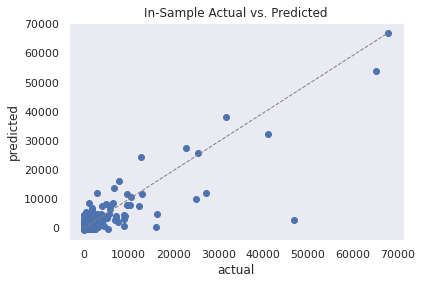

In [120]:

plt.scatter(y_train, train_preds)
plt.plot([0, max(y_train)], [0, max(train_preds)], color='gray', lw=1, linestyle='--')

plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('In-Sample Actual vs. Predicted')
plt.grid()

plt.show()

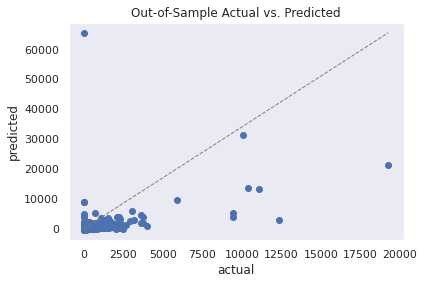

In [121]:

plt.scatter(y_test, test_preds)
plt.plot([0, max(y_test)], [0, max(test_preds)], color='gray', lw=1, linestyle='--')

plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Out-of-Sample Actual vs. Predicted')
plt.grid()

plt.show()

# Spot check all ML model

In [122]:
regressors={
    'LR':LinearRegression(),
    'LASSO':Lasso(),
    'Ridge':Ridge(),
    'EN':ElasticNet(),
    'KNN':KNeighborsRegressor(),
    'CART':DecisionTreeRegressor(),
    'SVR': SVR(),
    # ensembles
    'AB':AdaBoostRegressor(),
    'GBM':GradientBoostingRegressor(),
    'RF':RandomForestRegressor(),
    'ET':ExtraTreesRegressor(),
    #New:
    'XGB':XGBRegressor(), 
    'LGBM':LGBMRegressor(),
    'Ransac':RANSACRegressor(), 
    'Theil':TheilSenRegressor(), 
    'Huber':HuberRegressor(),
    'Poly2':Pipeline([
              ('Poly2', PolynomialFeatures(degree=2)),
              ('linear', LinearRegression(fit_intercept=False))]) 
}

In [123]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [130]:
num_folds=5
seed=42
scoring = {'r2': 'r2',
            'mse': "neg_mean_squared_error",
            'rmse': 'neg_root_mean_squared_error'}

time_=[]

names = []
cv_results_r2=[]
cv_results_mse=[]
cv_results_rmse=[]
cv_results_rmse_std=[]

for name, model in regressors.items():

  print(name)
  start = time.time()
  estimator = model
  #kfold = StratifiedKFold(n_splits=num_folds, random_state=seed,shuffle=True)
  cv_results = cross_validate(estimator, x_train, y_train, cv=num_folds, scoring=scoring,
                               return_train_score=True)
  names.append(name)
  cv_results_r2.append(cv_results['test_r2'].mean())
  cv_results_mse.append(cv_results['test_mse'].mean())
  cv_results_rmse.append(cv_results['test_rmse'].mean())
  cv_results_rmse_std.append(cv_results['test_rmse'].std())

  
  time_cal=time.time() - start
  print('rmse: %0.2f time : %0.3f' % (cv_results['test_rmse'].mean(),time_cal))
  time_.append(time_cal)

LR
rmse: -1563.93 time : 0.048
LASSO
rmse: -1564.27 time : 0.066
Ridge
rmse: -1563.94 time : 0.040
EN
rmse: -1572.47 time : 0.067
KNN
rmse: -1698.52 time : 0.221
CART
rmse: -2466.20 time : 0.112
SVR
rmse: -2636.91 time : 2.600
AB
rmse: -2120.48 time : 0.815
GBM
rmse: -1638.73 time : 1.752
RF
rmse: -1578.30 time : 5.611
ET
rmse: -1578.09 time : 2.932
XGB
[22:44:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse: -15

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The 

rmse: nan time : 0.495
Theil
rmse: -1396.75 time : 6.364
Huber


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



rmse: -1556.19 time : 0.480
Poly2
rmse: -35711.75 time : 0.152


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



In [139]:
df_results_val=pd.DataFrame(list(zip(names,cv_results_rmse,cv_results_mse,cv_results_r2,time_)),
                  columns=['Names','CV_rmse','CV_mse','CV_r2','Time'])
df_results_val=df_results_val.sort_values(by='CV_rmse',ascending=False)
df_results_val

,Names,CV_rmse,CV_mse,CV_r2,Time
14,Theil,-1396.751398,-2.157984e+06,0.596636,6.364108
15,Huber,-1556.192622,-2.715075e+06,0.554530,0.479927
0,LR,-1563.928467,-2.878953e+06,0.550613,0.048322
2,Ridge,-1563.939165,-2.878994e+06,0.550604,0.040478
1,LASSO,-1564.271805,-2.880594e+06,0.550478,0.066239
3,EN,-1572.465328,-2.908743e+06,0.543858,0.066609
10,ET,-1578.092783,-2.624249e+06,0.522743,2.932047
9,RF,-1578.300419,-2.571221e+06,0.496728,5.611251
11,XGB,-1587.515669,-2.632110e+06,0.468943,0.823293
8,GBM,-1638.733853,-2.811753e+06,0.325791,1.751806


In [140]:
df_results_val=df_results_val[:-2]

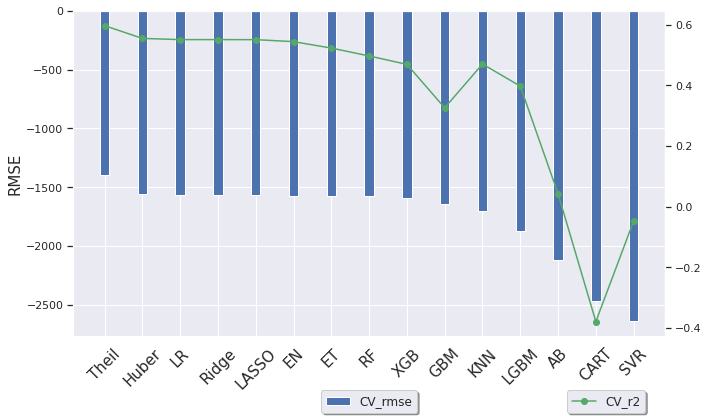

In [145]:
# Define name:

name=df_results_val['Names']
test_rmse=df_results_val['CV_rmse']
test_r2=df_results_val['CV_r2']
# Plot:
x = np.arange(len(name))
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x, test_rmse, color = 'b', width = 0.25,label='CV_rmse')


ax2 = ax.twinx()
ax2.plot(x, test_r2, color = 'g',marker='o',label='CV_r2')
ax2.secondary_yaxis('right')

ax.set_xticks(x)
ax.set_xticklabels(name,fontsize=15,rotation=45)
ax.set_ylabel('RMSE',fontsize=15)
ax2.set_ylabel('R2',fontsize=15)
#plt.gca().legend(loc ='center',bbox_to_anchor=(0.5, -0.2))
legend1=ax.legend(loc='center',bbox_to_anchor=(0.5, -0.2),shadow=True, fontsize='medium')
legend2=ax2.legend(loc='center',bbox_to_anchor=(0.9, -0.2),shadow=True, fontsize='medium')

plt.axis('off')
fig.tight_layout()
plt.show()

# Predict all model

In [146]:
reg_fit = TheilSenRegressor()
reg_fit.fit(x_train, y_train)
y_pred=reg_fit.predict(x_test)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
r2=r2_score(y_test,y_pred)
print('rmse: ',rmse)
print('r2: ',r2)

rmse:  701.217287016921
r2:  0.594869350352728


In [147]:
reg_fit = LinearRegression()
reg_fit.fit(x_train, y_train)
y_pred=reg_fit.predict(x_test)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
r2=r2_score(y_test,y_pred)
print('rmse: ',rmse)
print('r2: ',r2)

rmse:  2237.090167899021
r2:  -3.1234131372061755


In [158]:
regressors={
    'LR':LinearRegression(),
    'LASSO':Lasso(),
    'Ridge':Ridge(),
    'EN':ElasticNet(),
    'KNN':KNeighborsRegressor(),
    'CART':DecisionTreeRegressor(),
    'SVR': SVR(),
    # ensembles
    'AB':AdaBoostRegressor(),
    'GBM':GradientBoostingRegressor(),
    'RF':RandomForestRegressor(),
    'ET':ExtraTreesRegressor(),
    #New:
    'XGB':XGBRegressor(), 
    'LGBM':LGBMRegressor(),
    #'Ransac':RANSACRegressor(), 
    'Theil':TheilSenRegressor(), 
    'Huber':HuberRegressor(), very high
    'Poly2':Pipeline([
              #('Poly2', PolynomialFeatures(degree=2)),
              #('linear', LinearRegression(fit_intercept=False))]) 
}

In [159]:
name_=[]
rmse_=[]
r2_=[]
for name, model in regressors.items():
  print(name)
  name_.append(name)
  reg_fit = model
  reg_fit.fit(x_train, y_train)
  y_pred=reg_fit.predict(x_test)
  mse=mean_squared_error(y_test,y_pred)
  rmse=np.sqrt(mse)
  r2=r2_score(y_test,y_pred)
  rmse_.append(rmse)
  r2_.append(r2)

LR
LASSO
Ridge
EN
KNN
CART
SVR
AB
GBM
RF
ET
XGB
[23:09:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBM
Theil
Poly2


In [160]:
df_results=pd.DataFrame(list(zip(name_,rmse_,r2_,)),
                  columns=['Names','rmse_','r2_'])
df_results=df_results.sort_values(by='rmse_',ascending=True)
df_results

,Names,rmse_,r2_
9,RF,718.723031,0.574389
12,LGBM,733.702710,0.556463
13,Theil,736.086117,0.553576
10,ET,783.288965,0.494485
8,GBM,966.642262,0.230123
11,XGB,982.319656,0.204948
4,KNN,991.642260,0.189786
5,CART,1003.559692,0.170195
6,SVR,1144.609018,-0.079454
7,AB,2018.588231,-2.357263


In [162]:
df_results=df_results[:-1]

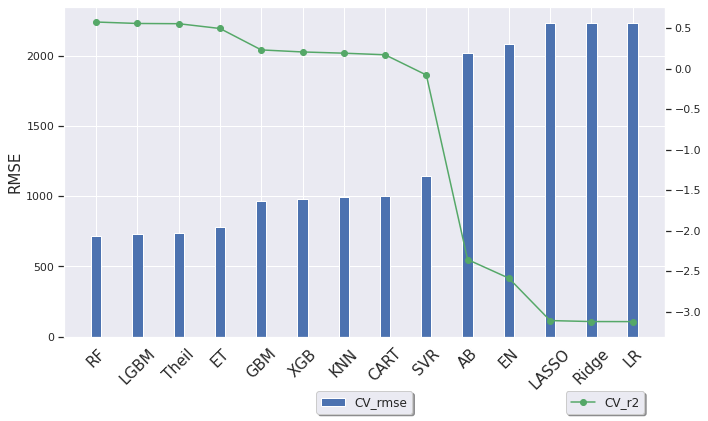

In [163]:
# Define name:

name=df_results['Names']
test_rmse=df_results['rmse_']
test_r2=df_results['r2_']
# Plot:
x = np.arange(len(name))
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x, test_rmse, color = 'b', width = 0.25,label='CV_rmse')


ax2 = ax.twinx()
ax2.plot(x, test_r2, color = 'g',marker='o',label='CV_r2')
ax2.secondary_yaxis('right')

ax.set_xticks(x)
ax.set_xticklabels(name,fontsize=15,rotation=45)
ax.set_ylabel('RMSE',fontsize=15)
ax2.set_ylabel('R2',fontsize=15)
#plt.gca().legend(loc ='center',bbox_to_anchor=(0.5, -0.2))
legend1=ax.legend(loc='center',bbox_to_anchor=(0.5, -0.2),shadow=True, fontsize='medium')
legend2=ax2.legend(loc='center',bbox_to_anchor=(0.9, -0.2),shadow=True, fontsize='medium')

plt.axis('off')
fig.tight_layout()
plt.show()